# Modelo não supervisionado - Clustering

1. Utiliza dataframe pré-processado

In [1]:
import pandas as pd

data = pd.read_csv('data/data-preprocessed.csv')
data

,PESSOA_PIPEDRIVE_id_person,PESSOA_PIPEDRIVE_id_gender,PESSOA_PIPEDRIVE_id_marrital_status,PESSOA_PIPEDRIVE_state,PESSOA_PIPEDRIVE_city,PESSOA_PIPEDRIVE_postal_code,PESSOA_PIPEDRIVE_contract_start_date,PESSOA_PIPEDRIVE_contract_end_date,PESSOA_PIPEDRIVE_Canal de Preferência,PESSOA_PIPEDRIVE_notes_count,...,WHOQOL_Físico_New,WHOQOL_Psicológico_New,WHOQOL_Social_New,WHOQOL_Ambiental_New,COMUNICARE_Problemas Abertos Bool,TWILIO_Data Última Mensagens Inbound Recente,last_stage_concluded,process_time,TWILIO_Data Última Mensagens Outbound Recente,TWILIO_Data Última Ligações Outbound Recente
0,250,64,82,São Paulo,São Paulo,04534-020,2021-01-28,NaN,0,1,...,4.0,3.7,3.7,4.0,0,0,Questionário,2022-04-29 03:00:00,0,0
1,254,64,80,North Carolina,Mecklenburg County,28203,2020-12-16,2021-11-18,0,0,...,3.7,3.5,4.0,3.9,0,0,Boas-vindas,2022-01-25 02:52:00,0,0
2,314,64,80,São Paulo,São Paulo,05337-030,2021-01-21,2021-03-16,0,0,...,3.7,3.5,4.0,3.9,0,0,Não iniciado,Não iniciado,0,0
3,315,64,80,São Paulo,São Paulo,NaN,2020-12-17,2021-04-27,0,0,...,3.7,3.5,4.0,3.9,0,0,Não iniciado,Não iniciado,0,0
4,317,64,80,São Paulo,São Paulo,05421-050,2021-01-18,2021-03-16,0,0,...,3.7,3.5,4.0,3.9,0,0,Não iniciado,Não iniciado,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,6009,63,80,São Paulo,São Caetano do Sul,09540-000,2023-11-30,NaN,0,0,...,3.7,3.5,4.0,3.9,0,0,Boas-vindas,Em aberto,0,0
1035,6010,63,80,Paraná,Curitiba,81750-010,2023-11-30,NaN,0,0,...,3.7,3.5,4.0,3.9,0,0,Boas-vindas,Em aberto,0,0
1036,6011,63,80,São Paulo,São Paulo,03381-130,2023-11-30,NaN,0,0,...,3.7,3.5,4.0,3.9,0,0,Boas-vindas,Em aberto,0,0
1037,6012,64,80,São Paulo,Hortolândia,13187-147,2023-11-30,NaN,239,0,...,3.7,3.5,4.0,3.9,0,0,Primeira reunião,Em aberto,0,0


2. Cria coluna de stay_time para utilizar como target, dropa colunas desnecessárias e aplica one hot encoding para certos casos

In [2]:
from datetime import datetime 
import numpy as np

tempo_permanencia = []

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"].items():
    if pd.notna(valor):
        index = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"].find(";")
        if index != -1:
            data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"] = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"][:index]

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_lost_time"].items():
    if pd.notna(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"]):
        tempo_1 = datetime.strptime(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"], '%Y-%m-%d')
        tempo_2 = datetime.strptime(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"], '%Y-%m-%d')
        tempo_permanencia.append(str(tempo_1 - tempo_2))
    else:
        tempo_1 = datetime.strptime(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"], '%Y-%m-%d')
        tempo_2 = datetime.strptime(data.loc[indice, "PESSOA_PIPEDRIVE_contract_start_date"], '%Y-%m-%d')
        tempo_permanencia.append(str(tempo_1 - tempo_2))

data['stay_time'] = tempo_permanencia

for indice, valor in data["stay_time"].items():
    index = data.loc[indice, "stay_time"].find(",")
    if index != -1:
        data.loc[indice, "stay_time"] = data.loc[indice, "stay_time"][:index]

data["stay_time"] = data["stay_time"].str.extract('(\d+) days').astype(float)
data["stay_time"] = np.nan_to_num(data["stay_time"], nan=0)

data.drop(columns=["PESSOA_PIPEDRIVE_id_person", "PESSOA_PIPEDRIVE_id_gender","PESSOA_PIPEDRIVE_id_marrital_status","PESSOA_PIPEDRIVE_state", 
                   "PESSOA_PIPEDRIVE_city","PESSOA_PIPEDRIVE_postal_code","PESSOA_PIPEDRIVE_contract_start_date","PESSOA_PIPEDRIVE_contract_end_date",
                   "PESSOA_PIPEDRIVE_Canal de Preferência","FUNIL_ASSINATURA_PIPEDRIVE_id_stage","FUNIL_ASSINATURA_PIPEDRIVE_id_org", "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service","FUNIL_ASSINATURA_PIPEDRIVE_lost_time",
                    "FUNIL_ONBOARDING_PIPEDRIVE_add_time","FUNIL_ONBOARDING_PIPEDRIVE_status","FUNIL_ONBOARDING_PIPEDRIVE_lost_reason", "FUNIL_ONBOARDING_PIPEDRIVE_activities_count",
                     "ATENDIMENTOS_AGENDA_Datas Atendimento Médico", "ATENDIMENTOS_AGENDA_Datas Acolhimento", "ATENDIMENTOS_AGENDA_Datas Prescrição", "last_stage_concluded",
                     "process_time"
                       ], inplace=True)


data = pd.get_dummies(data,columns=["FUNIL_ASSINATURA_PIPEDRIVE_status"], prefix='assinatura_status')
data = pd.get_dummies(data,columns=['FUNIL_ASSINATURA_PIPEDRIVE_lost_reason'], prefix='assinatura_lost_reason')

for indice, linha in data['assinatura_status_lost'].items():
  if linha != 1:
    data.drop(indice, inplace=True)

3. Normaliza os dados

In [3]:
from sklearn.discriminant_analysis import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

4. Aplica método elbow para encontrar o melhor número de clusterings

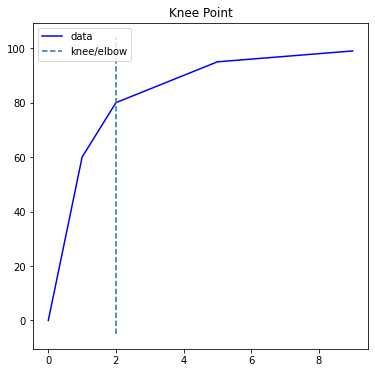

In [8]:
from kneed import KneeLocator, DataGenerator as dg
X, y = dg.concave_increasing()
kl = KneeLocator(X, y, curve="concave")
kl.plot_knee()


5. Aplica clustering como preditor e gera gráficos com resultados

c:\Users\Julia Paiva\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score (Training): 0.7216923695923576
Silhouette Score (Testing): 0.737176361229393
Adjusted Rand Index (Training): -0.0004991519415182852
Adjusted Rand Index (Testing): -0.0003900050641715511


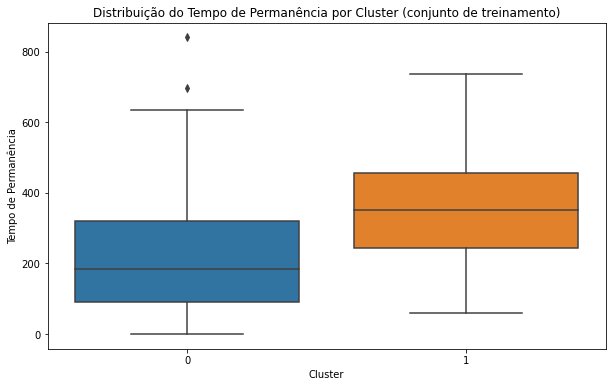

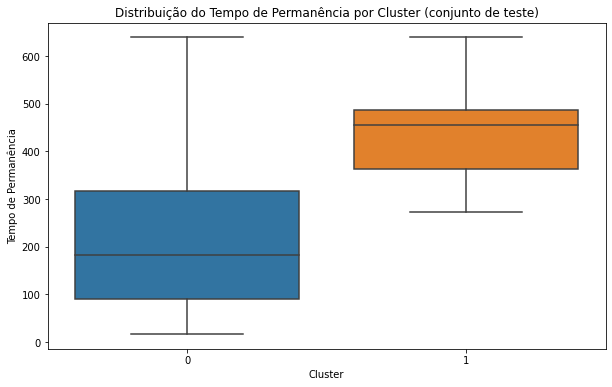

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
    
X = data.drop(columns=['stay_time'])  
y = data['stay_time']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
kmeans = KMeans(n_clusters=2, random_state=42)
X_train['cluster'] = kmeans.fit_predict(X_train)

X_test['cluster'] = kmeans.predict(X_test)

silhouette_train = silhouette_score(X_train, X_train['cluster'])
silhouette_test = silhouette_score(X_test, X_test['cluster'])

print(f"Silhouette Score (Training): {silhouette_train}")
print(f"Silhouette Score (Testing): {silhouette_test}")
    
ari_train = adjusted_rand_score(y_train, X_train['cluster'])
ari_test = adjusted_rand_score(y_test, X_test['cluster'])
    
print(f"Adjusted Rand Index (Training): {ari_train}")
print(f"Adjusted Rand Index (Testing): {ari_test}")
    
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y=data['stay_time'], data=X_train)
plt.title('Distribuição do Tempo de Permanência por Cluster (conjunto de treinamento)')
plt.xlabel('Cluster')
plt.ylabel('Tempo de Permanência')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y=data['stay_time'], data=X_test)
plt.title('Distribuição do Tempo de Permanência por Cluster (conjunto de teste)')
plt.xlabel('Cluster')
plt.ylabel('Tempo de Permanência')
plt.show()

6. Aplica PCA com duas componentes no dataset e plota os resultados em um scatterplot

c:\Users\Julia Paiva\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Variância explicada pelos dois primeiros componentes principais: [0.96285027 0.02116621]


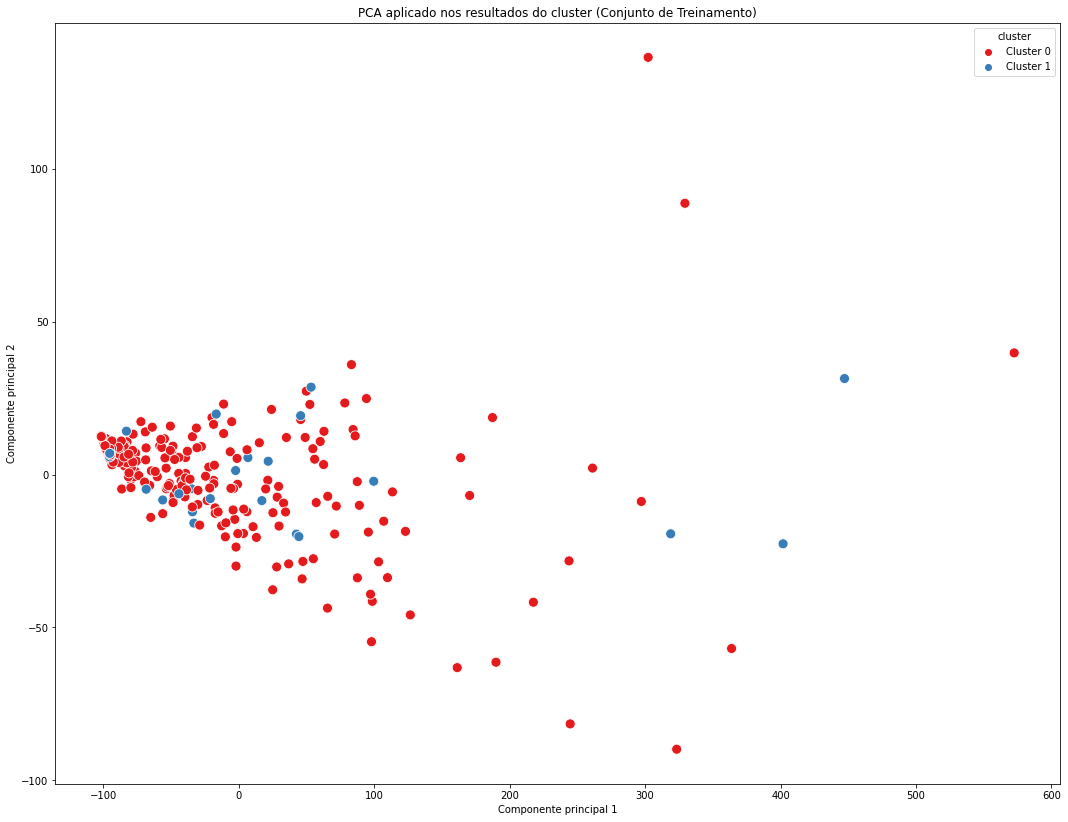

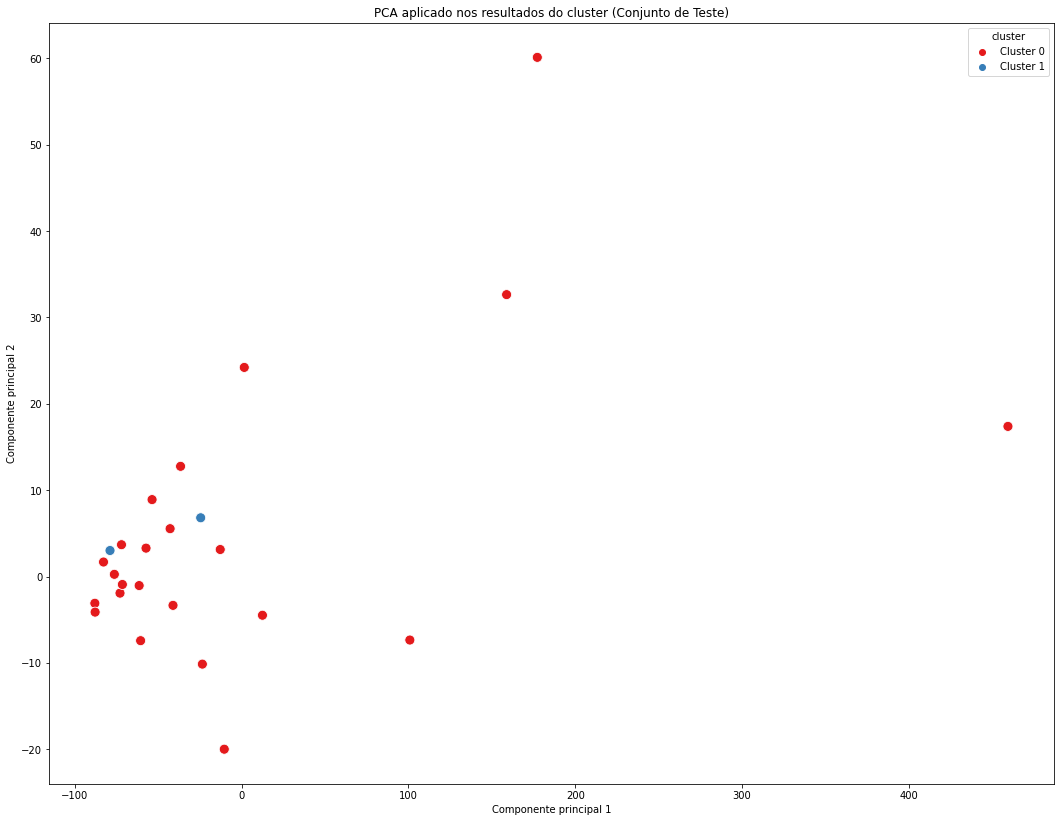

In [7]:

import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

kmeans = KMeans(n_clusters=2, random_state=42)
X_train['cluster'] = kmeans.fit_predict(X_train.drop(columns=['cluster']))
X_test['cluster'] = kmeans.predict(X_test.drop(columns=['cluster']))

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train.drop(columns=['cluster']))
X_test_pca = pca.fit_transform(X_test.drop(columns=['cluster']))

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Variância explicada pelos dois primeiros componentes principais: {explained_variance_ratio}")

pca_df_train = pd.DataFrame(X_train_pca, columns=['pc1', 'pc2'])
pca_df_train['cluster'] = X_train['cluster']
pca_df_train['target'] = y_train

pca_df_test = pd.DataFrame(X_test_pca, columns=['pc1', 'pc2'])
pca_df_test['cluster'] = X_test['cluster']
pca_df_test['target'] = y_test

cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1'}
pca_df_train['cluster'] = pca_df_train['cluster'].map(cluster_labels)
pca_df_test['cluster'] = pca_df_test['cluster'].map(cluster_labels)

plt.figure(figsize=(18, 14))
sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=pca_df_train, palette='Set1', s=100)
plt.title('PCA aplicado nos resultados do cluster (Conjunto de Treinamento)')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()

plt.figure(figsize=(18, 14))
sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=pca_df_test, palette='Set1', s=100)
plt.title('PCA aplicado nos resultados do cluster (Conjunto de Teste)')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()


## 7. Resultados
    
Clustering:

Treinamento:
    
- Silhouette Score: 0.7216923695923576
- Adjusted Rand Index: -0.0004991519415182852
    
Teste: 
    
- Silhouette Score: 0.737176361229393
- Adjusted Rand Index: -0.0003900050641715511
    
Boxplot:
    
- É possível observar dois agrupamentos feitos pelo algoritmo KMeans, o primeiro se referindo à pessoas que passam menos tempo na plataforma e o segundo às que passam mais tempo (o que fica mais claro no conjunto de teste). O primeiro grupo tem uma média de tempo de permanência por volta de 200 dias, e o segundo por volta de 400 e 500 dias. Em relação à limites inferiores e superiores, no conjunto de treinamento ambos tem uma dimensão parecida, indo de 0 a 700. No de testes a distribuição do primeiro grupo é bem ampla, indo de 0 a 600, enquanto o segundo tem uma distribuição menor, de 300 a 600. Eles podem representar dois grupos de pessoas, um que naturalmente fica mais tempo na plataforma, e outro que fica menos tempo.
    
As métricas utilizadas para avaliar o clustering foram Silhouette Score e Adjusted Rand Index. A primeira mede quão bem os clusters estão agrupados em relação uns aos outros, variando de -1  a 1, e a segunda mede a similaridade entre os clusters treinados e previstos, também variando de -1 a 1. 
    
PCA:
    
-  Variância explicada pelos componentes principais: [0.96285027 0.02116621].
    
A variância explicada indica a proporção de variância dos dados captada pelos componentes do PCA. Nesse caso, o primeiro componente explica cerca de 96%, enquanto o segundo, 2%. Portanto, o modelo consegue explicar 98% dos dados recebidos, indicando que esse modelo contém uma grande parte da informação contida nos dados originais.
    
Scatterplot:
    
- O scatterplot gerado pelo PCA pode ser considerado inconclusivo. Dados gerados pelos dois clusters gerados se misturam e se dispersam em relação às componentes principais, o que dificulta muito a análise.

## 7. Aplicação do modelo

Este modelo pode auxiliar a visualizar o comportamento dos usuários rem relação ao tempo de permanência de forma mais geral. Os resultados ilustrados pelo boxplot auxiliam a observar a distribuição de pessoas, qual é o tempo médio que passam na plataforma, quais são os valores máximos e mínimos, e possíveis outliers. Com isso, a empresa consegue observar tanto o padrão dos usuários quanto casos à parte.